# Assignment 2

## Question 1
### Part 1 (Canny Edge Detection)


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import depthai as dai

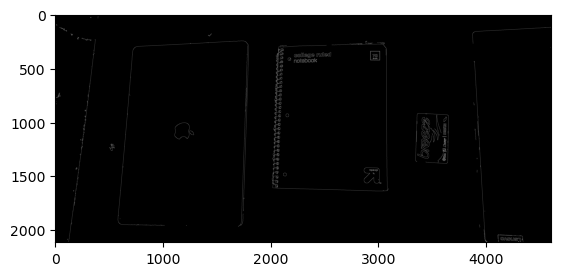

In [3]:
inpImg = cv2.imread("./Q1/Pic3.png")

# passing the image as input and setting the threshold values 
outImg = cv2.Canny(inpImg,50,180)

cv2.imwrite("Q1_CannyEdge_output.png",outImg)

plt.imshow(inpImg)
plt.imshow(outImg,cmap="gray")
plt.show()

### Part 1 (Harris Corner detection)

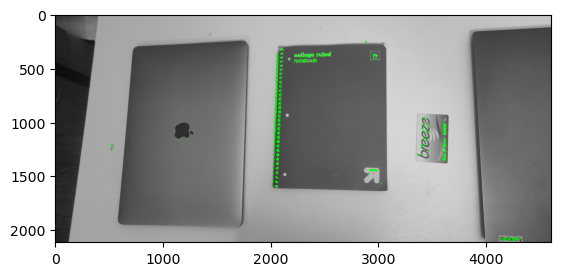

In [4]:
# loading image and converting it to GRAY
inpImg = cv2.imread("./Q1/Pic3.png")
imgGray = cv2.cvtColor(inpImg,cv2.COLOR_BGR2GRAY)

# Finding the harris corners on the Gray image
imgGray = np.float32(imgGray)
dest = cv2.cornerHarris(imgGray, 7, 23, 0.05)
dest = cv2.dilate(dest, None)
 
inpImg[dest > 0.01 * dest.max()]=[0, 255, 0]
 
cv2.imwrite("Q1_HarrisCorner_Output.png",inpImg)

plt.imshow(inpImg)
plt.show()

### Part 2 (Finding Homography) 

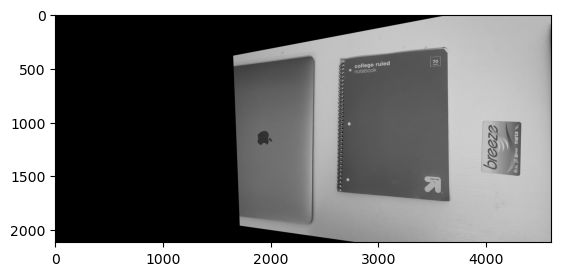

[[ 3.68162633e-01  3.06620418e-02  1.65489378e+03]
 [-1.53328260e-01  7.47335447e-01  3.85668395e+02]
 [-1.19859215e-04  9.65072708e-07  1.00000000e+00]]


In [5]:
#Found the points on MS Paint
src_points = np.array([[2185,855],[2156, 1268],[2431, 1286],[2454, 883],[2175, 1211]])
dest_points = np.array([[3364, 933],[3348, 1348],[3648, 1372],[3658, 947],[3367, 1295]])

homography, status = cv2.findHomography(src_points, dest_points)

im_src = cv2.imread('./Q1/Pic2.png')
im_dst = cv2.imread('./Q1/Pic3.png')

#using homography as homography matrix generates a warped output
im_out = cv2.warpPerspective(im_src, homography, (im_dst.shape[1],im_dst.shape[0]))

#warpSource output
plt.imshow(im_out)
plt.show()

print(homography)

## Question 2
### Stitiching Images (5 sets)

Success


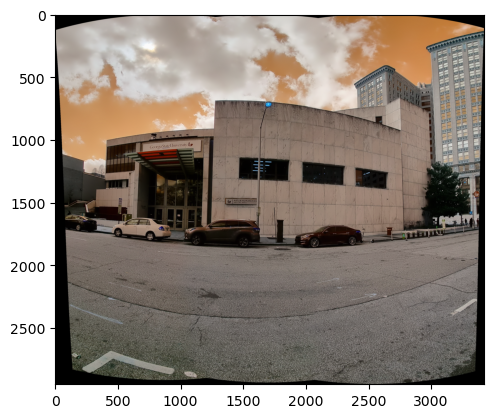

Success


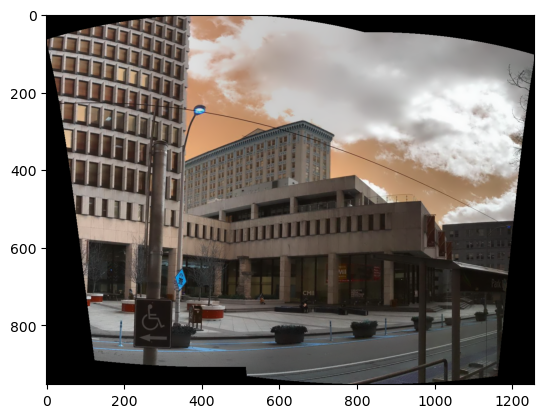

Success


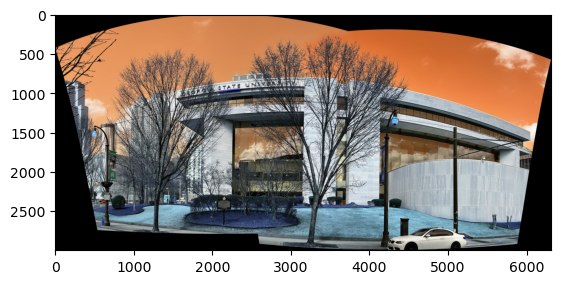

Success


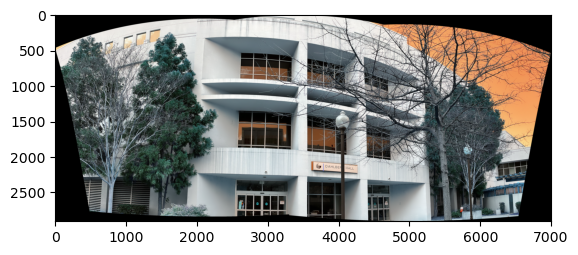

Success


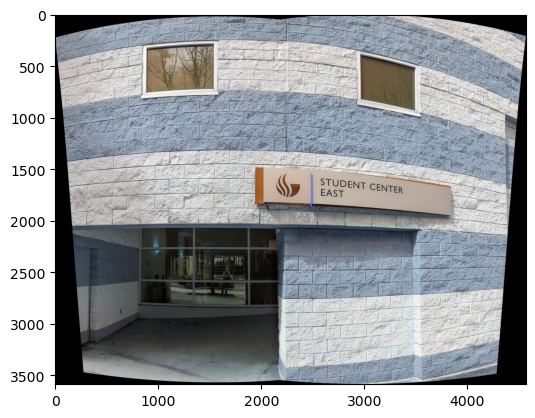

In [6]:
i = 1

#method to stitch images
def stitch(images):
	stitcher = cv2.Stitcher_create()
	(status, stitched_out) = stitcher.stitch(images)
	global i
	#if successful
	if status == 0:
		print("Success")
		name = "Q2_stitched_Output_Set " + str(i) + ".png"
		plt.imshow(stitched_out)
		#cv2.imshow(name, stitched_out)
		cv2.imwrite(name, stitched_out)
		plt.show()
		cv2.waitKey(0)
		i = i+1
	# else failed
	else:
		print("Failed ({})".format(status))



inp_set1 = ["./Q2/Sets/Arts_And_Humanities/Art and humanities01_team6.jpg","./Q2/Sets/Arts_And_Humanities/Art and humanities02_team6.jpg","./Q2/Sets/Arts_And_Humanities/Art and humanities03_team6.jpg"]
inp_set2 = ["./Q2/Sets/CMII/CMII_team6_1.jpeg","./Q2/Sets/CMII/CMII_team6_2.jpeg","./Q2/Sets/CMII/CMII_team6_3.jpeg"]
inp_set3 = ["./Q2/Sets/GSU-Building/GSU-Building-1.jpg","./Q2/Sets/GSU-Building/GSU-Building-2.jpg","./Q2/Sets/GSU-Building/GSU-Building-2.jpg"]
inp_set4 = ["./Q2/Sets/Dalhber/DAHLBER-1.jpg","./Q2/Sets/Dalhber/DAHLBER-2.jpg","./Q2/Sets/Dalhber/DAHLBER-3.jpg"]
inp_set5 = ["./Q2/Sets/StudentCenterEast/studentcentereast1.jpg","./Q2/Sets/StudentCenterEast/studentcentereast2.jpg","./Q2/Sets/StudentCenterEast/studentcentereast3.jpg"]

#making a superset of sets
images_set =[inp_set1, inp_set2, inp_set3, inp_set4, inp_set5]
images_input = []

#reading images from 5 sets iteratively and adding to the images_input[]
for set in images_set:
	for path in set:
		image = cv2.imread(path)
		images_input.append(image)
	stitch(images_input)
	images_input = []

## Question 3
### Integral image feed

In [ ]:
def integral_image(image, *, dtype=None):
    if dtype is None and image.real.dtype.kind == 'f':
        dtype = np.promote_types(image.dtype, np.float64)

    S = image
    for i in range(image.ndim):
        S = S.cumsum(axis=i, dtype=dtype)
    return S


def integrate(ii, start, end):
    start = np.atleast_2d(np.array(start))
    end = np.atleast_2d(np.array(end))
    rows = start.shape[0]

    total_shape = ii.shape
    total_shape = np.tile(total_shape, [rows, 1])

    start_negatives = start < 0
    end_negatives = end < 0
    start = (start + total_shape) * start_negatives + \
             start * ~(start_negatives)
    end = (end + total_shape) * end_negatives + \
           end * ~(end_negatives)

    if np.any((end - start) < 0):
        raise IndexError('end coordinates must be greater or equal to start')

    S = np.zeros(rows)
    bit_perm = 2 ** ii.ndim
    width = len(bin(bit_perm - 1)[2:])
    for i in range(bit_perm):  
        binary = bin(i)[2:].zfill(width)
        bool_mask = [bit == '1' for bit in binary]

        sign = (-1)**sum(bool_mask)

        bad = [np.any(((start[r] - 1) * bool_mask) < 0)
               for r in range(rows)]  

        corner_points = (end * (np.invert(bool_mask))) + \
                         ((start - 1) * bool_mask)

        S += [sign * ii[tuple(corner_points[r])] if(not bad[r]) else 0
              for r in range(rows)]
    return S

streams = []

# Enable one or both streams
streams.append('isp')


print("depthai version:", dai.__version__)
pipeline = dai.Pipeline()

cam = pipeline.createColorCamera()
cam.setResolution(dai.ColorCameraProperties.SensorResolution.THE_12_MP)

if 'isp' in streams:
    xout_isp = pipeline.createXLinkOut()
    xout_isp.setStreamName('isp')
    cam.isp.link(xout_isp.input)

device = dai.Device(pipeline)
device.startPipeline()

q_list = []
for s in streams:
    q = device.getOutputQueue(name=s, maxSize=3, blocking=True)
    q_list.append(q)
    # Make window resizable, and configure initial size
    cv2.namedWindow(s, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(s, (960, 540))

capture_flag = False
img_counter = 0
while True:
    for q in q_list:
        name = q.getName()
        data = q.get()
        width, height = data.getWidth(), data.getHeight()
        payload = data.getData()
        capture_file_info_str = f"capture_{name}_{img_counter}"
        if name == 'isp':
            shape = (height * 3 // 2, width)
            yuv420p = payload.reshape(shape).astype(np.uint8)
            bgr = cv2.cvtColor(yuv420p, cv2.COLOR_YUV2BGR_IYUV)
            # grayscale_img =  cv2.cvtColor(bgr,cv2.COLOR_BGR2GRAY)
            frame= cv2.copyMakeBorder(bgr, 50, 50, 50, 50, cv2.BORDER_CONSTANT, (0,0,0))
            frame=integral_image(frame)
            frame = frame/np.amax(frame)
            frame = np.clip(frame, 0,255)
        
        cv2.imshow(name, frame)
        if cv2.waitKey(1) == ord('q'):
            break

depthai version: 2.19.1.0


C:\Users\kanya\AppData\Local\Temp\ipykernel_12940\2380308754.py:66: DeprecationWarning: Device(pipeline) starts the pipeline automatically. Use Device() and startPipeline(pipeline) otherwise
  device.startPipeline()


## Question 4
### SIFT feature Stitiching

Success


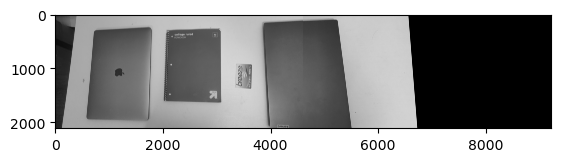

In [7]:
from random import randrange

IMG1Original = cv2.imread("./Q4/Pic1.png")
img1 = cv2.cvtColor(IMG1Original,cv2.COLOR_BGR2GRAY)
IMG2Original = cv2.imread("./Q4/Pic3.png")
img2 = cv2.cvtColor(IMG2Original,cv2.COLOR_BGR2GRAY)


#Finding key points and descriptor using SIFT
sift = cv2.SIFT_create()
keyPts1, des1 = sift.detectAndCompute(img1,None)
keyPts2, des2 = sift.detectAndCompute(img2,None)


bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
     good.append(m)
     matches = np.asarray(good)

if len(matches[:,0]) >= 4:
    print("Success")
    source = np.float32([ keyPts1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dest = np.float32([ keyPts2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    Homography, masked = cv2.findHomography(source, dest, cv2.RANSAC, 5.0)
    #print H
else:
    print("Failed: not enough key points")

dest = cv2.warpPerspective(IMG1Original,Homography,(IMG2Original.shape[1] + IMG1Original.shape[1], IMG2Original.shape[0]))
dest[0:IMG2Original.shape[0], 0:IMG2Original.shape[1]] = IMG2Original
cv2.imwrite("Q4_SIFT_output.jpg",dest)
plt.imshow(dest)
plt.show()

## Question 5
### ORB feature stitching

Success


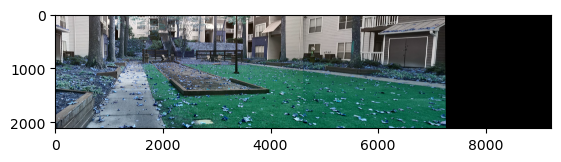

In [8]:
IMG1Original = cv2.imread("./Q5/Pic1.png")
img1 = cv2.cvtColor(IMG1Original,cv2.COLOR_BGR2GRAY)
IMG2Original = cv2.imread("./Q5/Pic3.png")
img2 = cv2.cvtColor(IMG2Original,cv2.COLOR_BGR2GRAY)


#Finding key points and descriptor using ORB
orb = cv2.ORB_create()
keyPts1, des1 =orb.detectAndCompute(img1,None)
keyPts2, des2 = orb.detectAndCompute(img2,None)


bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
     good.append(m)
     matches = np.asarray(good)

if len(matches[:,0]) >= 4:
    print("Success")
    source = np.float32([ keyPts1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dest = np.float32([ keyPts2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    Homography, masked = cv2.findHomography(source, dest, cv2.RANSAC, 5.0)
    #print H
else:
    print("Failed: not enough key points")

dest = cv2.warpPerspective(IMG1Original,Homography,(IMG2Original.shape[1] + IMG1Original.shape[1], IMG2Original.shape[0]))
dest[0:IMG2Original.shape[0], 0:IMG2Original.shape[1]] = IMG2Original
cv2.imwrite("Q5_ORB_Output.jpg",dest)
plt.imshow(dest)
plt.show()